In [8]:
import jax.numpy as jnp
import numpy as np
import jax
import scipy
from scipy import stats
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time
import optax
from tqdm import tqdm
from functools import partial
from tensorflow_probability.substrates import jax as tfp
from jax.config import config
import argparse
import os
import pwd
tfd = tfp.distributions
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rc('text', usetex=False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

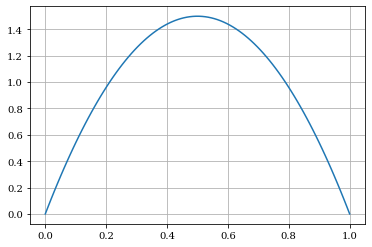

In [9]:
interval = jnp.linspace(0, 1, 100)
a = 2
b = 2
interval_pdf = jax.scipy.stats.beta.pdf(interval, a, b)
plt.figure()
plt.plot(interval, interval_pdf)
plt.show()

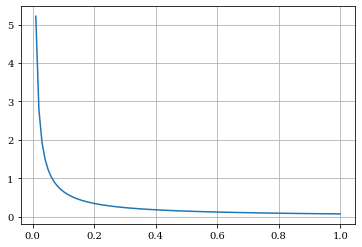

In [10]:

interval = jnp.linspace(0, 1, 100)
interval_pdf = jax.scipy.stats.gamma.pdf(interval, a=0.1, scale=10.)
plt.figure()
plt.plot(interval, interval_pdf)
plt.show()

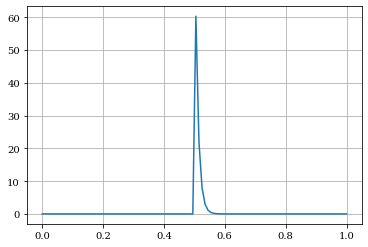

In [11]:
beta_lab = 0.5
rate = 100.0
scale = 1. / rate
interval = jnp.linspace(0, 1, 100)
interval_pdf = jax.scipy.stats.gamma.pdf(interval, a=1., loc=beta_lab, scale=scale)
plt.figure()
plt.plot(interval, interval_pdf)
plt.show()


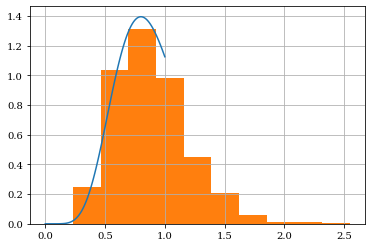

In [34]:
seed = int(time.time())
rng_key = jax.random.PRNGKey(seed)


beta_lab = 0.8
rate = 10.0
scale = 1. / rate
a = 1 + rate * beta_lab

interval = jnp.linspace(0, 1, 100)
interval_pdf = jax.scipy.stats.gamma.pdf(interval, a=a, scale=scale)

samples = jax.random.gamma(rng_key, a, shape=(2000, 1))
samples = samples * scale

# samples_ = scipy.stats.gamma.rvs(a=a, scale=scale, size=2000)

plt.figure()
plt.plot(interval, interval_pdf)
plt.hist(np.array(samples), density=True)
# plt.hist(np.array(samples_), density=True)
plt.show()



In [29]:
def kme_Matern_Gamma(alpha, beta, l, y):
    """
    :param alpha: scalar
    :param beta: scalar
    :param l: scalar
    :param y: (N, )
    :return: (N, )
    """
    aprime = alpha + 1
    bprime = beta + (jnp.sqrt(3.) / l)
    poly_term = (jnp.sqrt(3.) / l * ((beta ** alpha) / (bprime ** aprime)) * alpha) \
                + (1. - jnp.sqrt(3) / l * y) * ((beta / bprime) ** alpha)
    exp_term = jnp.exp(jnp.sqrt(3.) * y / l)
    return poly_term * exp_term

def my_Matern(x, y, l):
    """
    :param x: N*D
    :param y: M*D
    :param l: scalar
    :return: N*M
    """
    kernel = tfp.math.psd_kernels.MaternThreeHalves(amplitude=1., length_scale=l)
    K = kernel.matrix(x, y)
    return K


In [30]:
alpha = a
beta = 1. / scale
l = 0.2
y = samples

phi = kme_Matern_Gamma(alpha, beta, l, y)
print(phi)

[[-1.76611566]
 [-4.02852304]
 [-1.21496655]
 ...
 [-1.50218337]
 [-1.80711406]
 [-4.54980169]]


In [31]:
K = my_Matern(y, y, l)
print(K.mean(0))

[0.67499484 0.62937078 0.68811039 ... 0.68118094 0.67405077 0.6204658 ]


In [38]:
def log_prior(beta, beta_0, rate, rng_key):
    scale = 1. / rate
    logpdf = 1. / scale * jax.scipy.stats.gamma.logpdf(beta / scale, a=1 + rate * beta_0, loc=beta_0)
    return logpdf


In [39]:
beta_0 = 0.2

log_prior_fn = partial(log_prior, beta_0=beta_0, rate=rate, rng_key=rng_key)
grad_log_prior_fn = jax.grad(log_prior_fn)




In [40]:
grad_log_prior_fn(0.18)

Array(25., dtype=float64, weak_type=True)